<a href="https://colab.research.google.com/github/Puthalir/Puthalir.github.io/blob/main/Day_2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
pip install selenium pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.2/499.2 kB 21.7 MB/s eta 0:00:00


In [20]:
import requests
from bs4 import BeautifulSoup
import time

# Define headers to mimic a browser visit
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"
}

# Base URL components
base_url = "https://www.indeed.com/jobs"
query_params = {
    "q": "data scientist",
    "l": "Bolton, MA",
    "start": 0
}

# Open a file to write the job listings
with open("indeed_jobs.txt", "w", encoding="utf-8") as file:
    for page in range(5):  # Iterate over the first 5 pages
        query_params["start"] = page * 10  # Indeed shows 10 jobs per page
        response = requests.get(base_url, headers=headers, params=query_params)

        if response.status_code != 200:
            print(f"Failed to retrieve page {page + 1}")
            continue

        soup = BeautifulSoup(response.text, "html.parser")
        job_cards = soup.find_all("div", class_="job_seen_beacon")

        for job in job_cards:
            title_elem = job.find("h2", class_="jobTitle")
            company_elem = job.find("span", class_="companyName")
            location_elem = job.find("div", class_="companyLocation")

            title = title_elem.get_text(strip=True) if title_elem else "N/A"
            company = company_elem.get_text(strip=True) if company_elem else "N/A"
            location = location_elem.get_text(strip=True) if location_elem else "N/A"

            file.write(f"Job Title: {title}\n")
            file.write(f"Company: {company}\n")
            file.write(f"Location: {location}\n")
            file.write("-" * 40 + "\n")

        print(f"Page {page + 1} scraped successfully.")
        time.sleep(2)  # Delay to prevent overwhelming the server


Failed to retrieve page 1
Failed to retrieve page 2
Failed to retrieve page 3
Failed to retrieve page 4
Failed to retrieve page 5


In [21]:
pip install requests beautifulsoup4

In [22]:
import requests
from bs4 import BeautifulSoup
import time
import random
import csv
import os

def scrape_indeed_jobs(query, location, num_pages=5):
    """
    Scrape Indeed job listings for a given query and location.

    Args:
        query (str): Job title or keyword to search for
        location (str): Location to search in
        num_pages (int): Number of pages to scrape (default: 5)

    Returns:
        list: List of job listings (each as a dictionary)
    """
    # Format the search parameters for the URL
    formatted_query = query.replace(' ', '+')
    formatted_location = location.replace(' ', '+').replace(',', '%2C')

    # List to store all job listings
    all_jobs = []

    # User-Agent to mimic a browser
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }

    # Loop through pages
    for page in range(num_pages):
        # Calculate the start parameter (10 jobs per page)
        start = page * 10

        # Create the URL for the current page
        url = f"https://www.indeed.com/jobs?q={formatted_query}&l={formatted_location}&start={start}"

        print(f"Scraping page {page+1}/{num_pages}: {url}")

        try:
            # Make the request
            response = requests.get(url, headers=headers)

            # Check if request was successful
            if response.status_code == 200:
                # Parse the HTML
                soup = BeautifulSoup(response.text, 'html.parser')

                # Find all job cards
                job_cards = soup.find_all('div', class_='job_seen_beacon')

                if not job_cards:
                    print(f"No job cards found on page {page+1}. Indeed may have changed their HTML structure or is blocking scraping.")
                    continue

                # Extract data from each job card
                for card in job_cards:
                    job_data = {}

                    # Extract job title
                    title_element = card.find('a', class_='jcs-JobTitle')
                    if title_element:
                        job_data['title'] = title_element.text.strip()

                        # Extract job URL
                        job_url = title_element.get('href')
                        if job_url and job_url.startswith('/'):
                            job_data['url'] = f"https://www.indeed.com{job_url}"
                        else:
                            job_data['url'] = job_url
                    else:
                        job_data['title'] = "N/A"
                        job_data['url'] = "N/A"

                    # Extract company name
                    company_element = card.find('span', class_='companyName')
                    job_data['company'] = company_element.text.strip() if company_element else "N/A"

                    # Extract location
                    location_element = card.find('div', class_='companyLocation')
                    job_data['location'] = location_element.text.strip() if location_element else "N/A"

                    # Extract salary if available
                    salary_element = card.find('div', class_='metadata salary-snippet-container')
                    job_data['salary'] = salary_element.text.strip() if salary_element else "Not specified"

                    # Extract job snippet/description
                    description_element = card.find('div', class_='job-snippet')
                    job_data['description'] = description_element.text.strip() if description_element else "N/A"

                    # Extract date posted
                    date_element = card.find('span', class_='date')
                    job_data['date_posted'] = date_element.text.strip() if date_element else "N/A"

                    # Add to our list of jobs
                    all_jobs.append(job_data)

                # Add a delay between requests to avoid being blocked
                time.sleep(random.uniform(2, 5))

            else:
                print(f"Failed to fetch page {page+1}. Status code: {response.status_code}")

        except Exception as e:
            print(f"Error scraping page {page+1}: {str(e)}")

    print(f"Scraped a total of {len(all_jobs)} job listings.")
    return all_jobs

def save_to_csv(jobs, filename="indeed_jobs.csv"):
    """Save job listings to CSV file"""
    if not jobs:
        print("No jobs to save.")
        return

    try:
        with open(filename, 'w', newline='', encoding='utf-8') as csvfile:
            # Get the keys from the first job to use as field names
            fieldnames = jobs[0].keys()
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

            writer.writeheader()
            for job in jobs:
                writer.writerow(job)

        print(f"Successfully saved {len(jobs)} jobs to {filename}")
    except Exception as e:
        print(f"Error saving to CSV: {str(e)}")

def save_to_txt(jobs, filename="indeed_jobs.txt"):
    """Save job listings to TXT file"""
    if not jobs:
        print("No jobs to save.")
        return

    try:
        with open(filename, 'w', encoding='utf-8') as txtfile:
            txtfile.write(f"INDEED JOB LISTINGS\n")
            txtfile.write(f"Total Jobs Found: {len(jobs)}\n")
            txtfile.write("="*50 + "\n\n")

            for i, job in enumerate(jobs, 1):
                txtfile.write(f"Job #{i}\n")
                txtfile.write(f"Title: {job.get('title', 'N/A')}\n")
                txtfile.write(f"Company: {job.get('company', 'N/A')}\n")
                txtfile.write(f"Location: {job.get('location', 'N/A')}\n")
                txtfile.write(f"Salary: {job.get('salary', 'Not specified')}\n")
                txtfile.write(f"Date Posted: {job.get('date_posted', 'N/A')}\n")
                txtfile.write(f"Description: {job.get('description', 'N/A')}\n")
                txtfile.write(f"URL: {job.get('url', 'N/A')}\n")
                txtfile.write("-"*50 + "\n\n")

        print(f"Successfully saved {len(jobs)} jobs to {filename}")
    except Exception as e:
        print(f"Error saving to TXT: {str(e)}")

def main():
    # Get user input
    query = input("Enter job title or keywords (default: 'data scientist'): ") or "data scientist"
    location = input("Enter location (default: 'Bolton, MA'): ") or "Bolton, MA"
    num_pages = int(input("Enter number of pages to scrape (default: 5): ") or 5)

    # Scrape the jobs
    jobs = scrape_indeed_jobs(query, location, num_pages)

    if jobs:
        # Save to both CSV and TXT formats
        save_to_csv(jobs)
        save_to_txt(jobs)
    else:
        print("No jobs were found or there was an issue with scraping.")

if __name__ == "__main__":
    main()


Enter job title or keywords (default: 'data scientist'): data scientist
Enter location (default: 'Bolton, MA'): Bolton, MA
Enter number of pages to scrape (default: 5): 5
Scraping page 1/5: https://www.indeed.com/jobs?q=data+scientist&l=Bolton%2C+MA&start=0
Failed to fetch page 1. Status code: 403
Scraping page 2/5: https://www.indeed.com/jobs?q=data+scientist&l=Bolton%2C+MA&start=10
Failed to fetch page 2. Status code: 403
Scraping page 3/5: https://www.indeed.com/jobs?q=data+scientist&l=Bolton%2C+MA&start=20
Failed to fetch page 3. Status code: 403
Scraping page 4/5: https://www.indeed.com/jobs?q=data+scientist&l=Bolton%2C+MA&start=30
Failed to fetch page 4. Status code: 403
Scraping page 5/5: https://www.indeed.com/jobs?q=data+scientist&l=Bolton%2C+MA&start=40
Failed to fetch page 5. Status code: 403
Scraped a total of 0 job listings.
No jobs were found or there was an issue with scraping.


In [23]:
import requests
from bs4 import BeautifulSoup
import time
import random
import csv

def scrape_indeed_jobs(query, location, num_pages=5):
    formatted_query = query.replace(' ', '+')
    formatted_location = location.replace(' ', '+').replace(',', '%2C')

    all_jobs = []

    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64)'
    }

    for page in range(num_pages):
        start = page * 10
        url = f"https://www.indeed.com/jobs?q={formatted_query}&l={formatted_location}&start={start}"
        print(f"Scraping page {page + 1}/{num_pages}: {url}")

        try:
            response = requests.get(url, headers=headers)
            if response.status_code == 200:
                soup = BeautifulSoup(response.text, 'html.parser')
                job_cards = soup.find_all('div', class_='job_seen_beacon')

                for card in job_cards:
                    job_data = {}
                    title_element = card.find('a', class_='jcs-JobTitle')
                    job_data['title'] = title_element.text.strip() if title_element else "N/A"
                    job_data['url'] = f"https://www.indeed.com{title_element.get('href')}" if title_element else "N/A"

                    company = card.find('span', class_='companyName')
                    job_data['company'] = company.text.strip() if company else "N/A"

                    location = card.find('div', class_='companyLocation')
                    job_data['location'] = location.text.strip() if location else "N/A"

                    salary = card.find('div', class_='salary-snippet')
                    job_data['salary'] = salary.text.strip() if salary else "Not specified"

                    description = card.find('div', class_='job-snippet')
                    job_data['description'] = description.text.strip().replace('\n', ' ') if description else "N/A"

                    date = card.find('span', class_='date')
                    job_data['date_posted'] = date.text.strip() if date else "N/A"

                    all_jobs.append(job_data)

                time.sleep(random.uniform(1.5, 3.0))
            else:
                print(f"Failed to fetch page {page + 1}. Status: {response.status_code}")
        except Exception as e:
            print(f"Error scraping page {page + 1}: {str(e)}")

    print(f"Scraped {len(all_jobs)} jobs.")
    return all_jobs

def save_to_csv(jobs, filename="indeed_jobs.csv"):
    if not jobs:
        print("No jobs to save.")
        return
    try:
        with open(filename, 'w', newline='', encoding='utf-8') as file:
            writer = csv.DictWriter(file, fieldnames=jobs[0].keys())
            writer.writeheader()
            writer.writerows(jobs)
        print(f"Saved {len(jobs)} jobs to {filename}")
    except Exception as e:
        print(f"Error saving CSV: {str(e)}")

def main():
    query = input("Enter job title (default: 'data scientist'): ") or "data scientist"
    location = input("Enter location (default: 'Bolton, MA'): ") or "Bolton, MA"
    pages = int(input("Enter number of pages to scrape (default: 5): ") or 5)

    jobs = scrape_indeed_jobs(query, location, pages)
    if jobs:
        save_to_csv(jobs)
    else:
        print("No job data to save.")

if __name__ == "__main__":
    main()


Enter job title (default: 'data scientist'): data scientist
Enter location (default: 'Bolton, MA'): Bolton, MA
Enter number of pages to scrape (default: 5): 5
Scraping page 1/5: https://www.indeed.com/jobs?q=data+scientist&l=Bolton%2C+MA&start=0
Failed to fetch page 1. Status: 403
Scraping page 2/5: https://www.indeed.com/jobs?q=data+scientist&l=Bolton%2C+MA&start=10
Failed to fetch page 2. Status: 403
Scraping page 3/5: https://www.indeed.com/jobs?q=data+scientist&l=Bolton%2C+MA&start=20
Failed to fetch page 3. Status: 403
Scraping page 4/5: https://www.indeed.com/jobs?q=data+scientist&l=Bolton%2C+MA&start=30
Failed to fetch page 4. Status: 403
Scraping page 5/5: https://www.indeed.com/jobs?q=data+scientist&l=Bolton%2C+MA&start=40
Failed to fetch page 5. Status: 403
Scraped 0 jobs.
No job data to save.


🔹 Shape: (1309, 14)

🔹 Columns:
 Index(['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket',
       'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest'],
      dtype='object')

🔹 Data Types:
 pclass         int64
survived       int64
name          object
sex           object
age          float64
sibsp          int64
parch          int64
ticket        object
fare         float64
cabin         object
embarked      object
boat          object
body         float64
home.dest     object
dtype: object

🔹 First 5 Rows:
    pclass  survived                                             name     sex  \
0       1         1                    Allen, Miss. Elisabeth Walton  female   
1       1         1                   Allison, Master. Hudson Trevor    male   
2       1         0                     Allison, Miss. Helen Loraine  female   
3       1         0             Allison, Mr. Hudson Joshua Creighton    male   
4       1         0  Allison, Mrs. Hudson J C (Bessie Wald

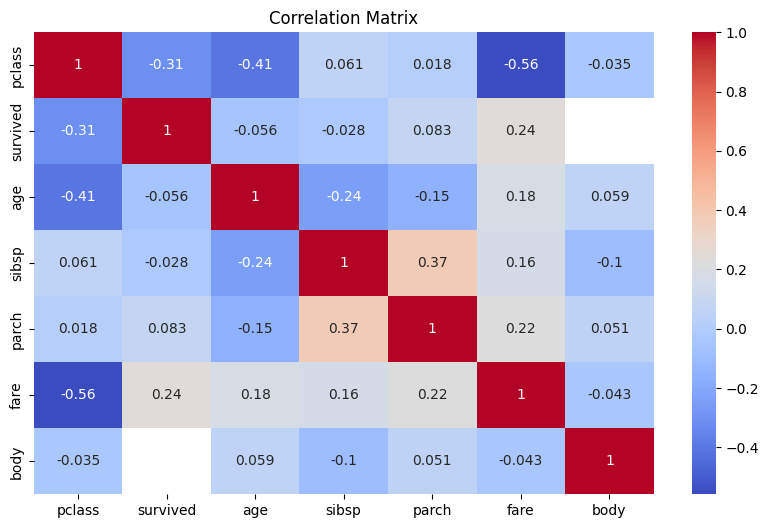

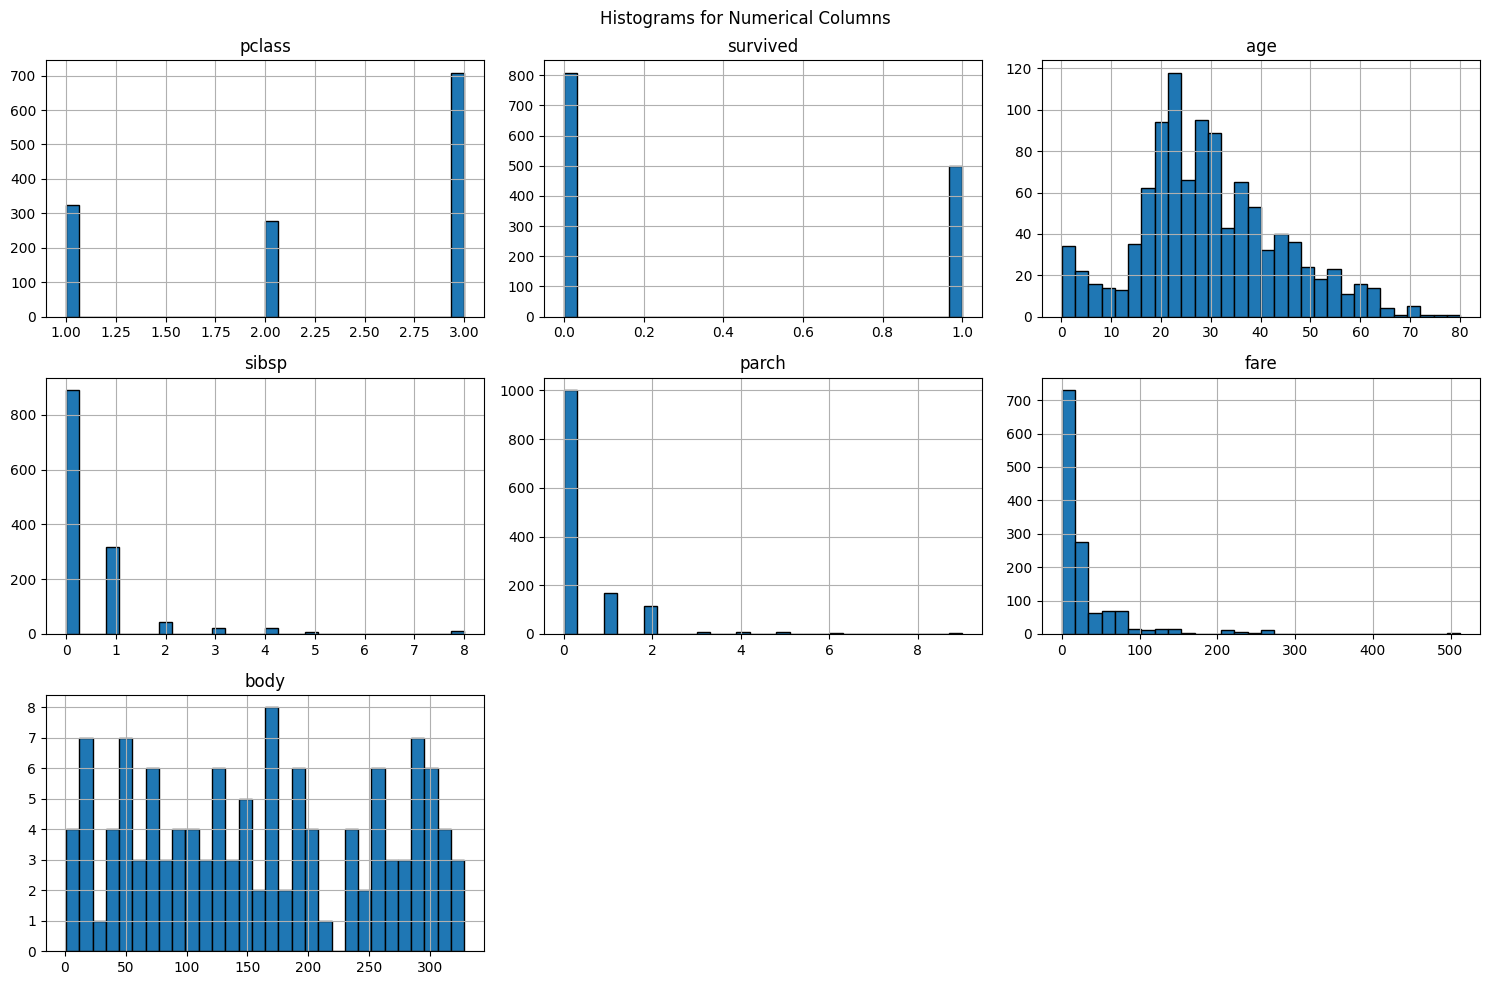

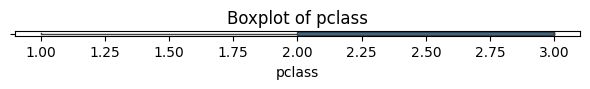

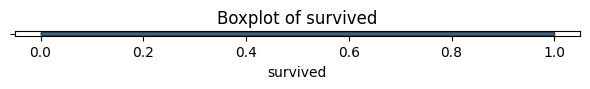

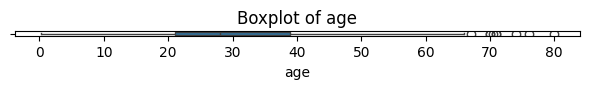

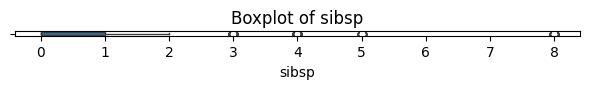

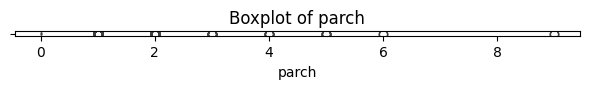

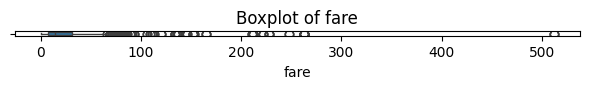

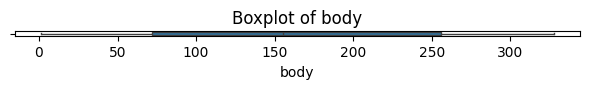

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Excel file
df = pd.read_excel("titanic3.xls")

# Basic overview
print("🔹 Shape:", df.shape)
print("\n🔹 Columns:\n", df.columns)
print("\n🔹 Data Types:\n", df.dtypes)
print("\n🔹 First 5 Rows:\n", df.head())

# Missing values
print("\n🔹 Missing Values:\n", df.isnull().sum())

# Summary statistics
print("\n🔹 Summary Statistics:\n", df.describe(include='all'))

# Check for duplicates
print("\n🔹 Duplicates:", df.duplicated().sum())

# Unique values per column
print("\n🔹 Unique values per column:")
for col in df.columns:
    print(f"{col}: {df[col].nunique()}")

# Value counts for categorical features
categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
    print(f"\n🔸 Value counts for {col}:\n{df[col].value_counts()[:5]}")

# Correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# Histograms for numerical features
df.select_dtypes(include=np.number).hist(bins=30, figsize=(15, 10), edgecolor='black')
plt.suptitle("Histograms for Numerical Columns")
plt.tight_layout()
plt.show()

# Boxplots for outlier detection
for col in df.select_dtypes(include=np.number).columns:
    plt.figure(figsize=(6, 1))
    sns.boxplot(data=df, x=col)
    plt.title(f"Boxplot of {col}")
    plt.tight_layout()
    plt.show()


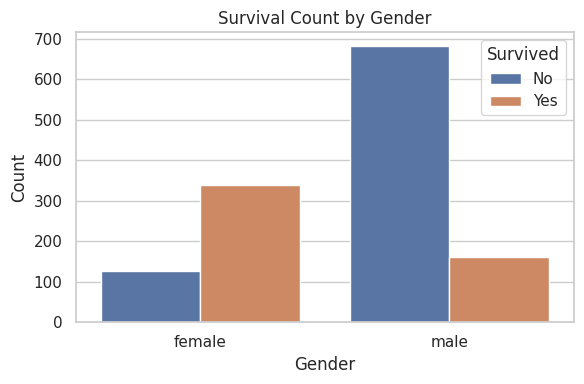

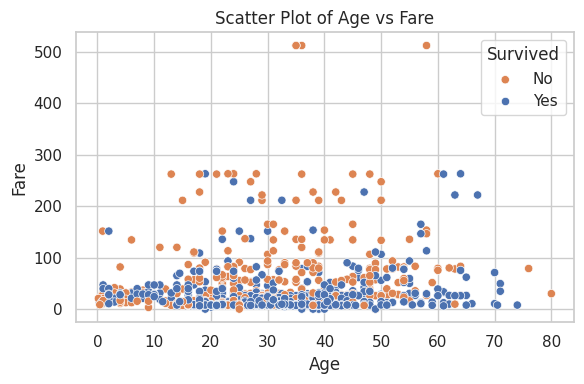

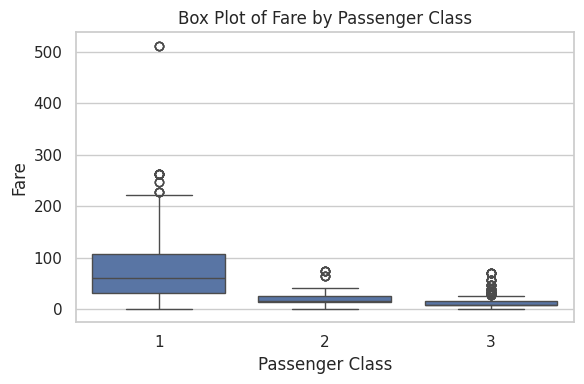

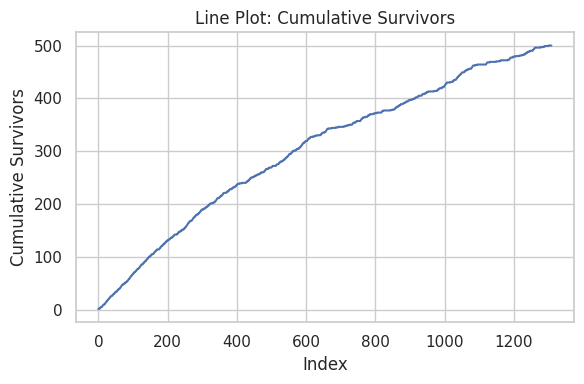

In [25]:

# Load dataset
df = pd.read_excel("titanic3.xls")

# Set plot style
sns.set(style="whitegrid")

# 🔹 1. Bar Plot: Survival count by Gender
plt.figure(figsize=(6, 4))
sns.countplot(x='sex', hue='survived', data=df)
plt.title("Survival Count by Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.legend(title="Survived", labels=["No", "Yes"])
plt.tight_layout()
plt.show()

# 🔹 2. Scatter Plot: Age vs Fare (color by Survival)
plt.figure(figsize=(6, 4))
sns.scatterplot(x='age', y='fare', hue='survived', data=df)
plt.title("Scatter Plot of Age vs Fare")
plt.xlabel("Age")
plt.ylabel("Fare")
plt.legend(title="Survived", labels=["No", "Yes"])
plt.tight_layout()
plt.show()

# 🔹 3. Box Plot: Fare distribution by Passenger Class
plt.figure(figsize=(6, 4))
sns.boxplot(x='pclass', y='fare', data=df)
plt.title("Box Plot of Fare by Passenger Class")
plt.xlabel("Passenger Class")
plt.ylabel("Fare")
plt.tight_layout()
plt.show()

# 🔹 4. Line (Pipeline) Plot: Cumulative survivors over entries
# First, drop NaNs in 'survived' and compute cumulative sum
df_filtered = df.dropna(subset=["survived"])
df_filtered['CumulativeSurvivors'] = df_filtered['survived'].cumsum()

plt.figure(figsize=(6, 4))
plt.plot(df_filtered.index, df_filtered['CumulativeSurvivors'])
plt.title("Line Plot: Cumulative Survivors")
plt.xlabel("Index")
plt.ylabel("Cumulative Survivors")
plt.tight_layout()
plt.show()
